Model Building
This workbook is compiled to get some information about the dataset, build the CNN, Optimize the process at a few steps and take some countermeasures for overfitting, and then give a summary fo the performance

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
import os
import numpy as np
import matplotlib.pyplot as plt

The next two steps are just to help reduce the computation time as it takes a long time to train the model

In [2]:
tf.config.optimizer.set_jit(True)

In [3]:
#early stopping implemented to reduce very long processing times
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Define the batch size, set the number of epochs to be sufficicently large so that the early stopping function can work, defient he image height and width, and the training and validatation set paths.

In [27]:
#a number of variations of these parameters were used to try and find a balance of best accuracy and runtime, smaller batch sizes made it take much much longer to run a training session
batch_size = 128
epochs = 100
num_steps = 100
#image height and width were reduced to try and make it run faster but it didnt have much of an effect so the full image sizes were used
IMG_HEIGHT = 196
IMG_WIDTH = 129
TRAIN_PATH = 'train2'
VAL_PATH = 'test2'

There are varying nuymbers of samples for each genre, so we need to calculate the weight of each genre so that we can try to not overtrain the model on certain genres

In [45]:
classes = sorted(os.listdir(TRAIN_PATH))
num_samples = []

for c in classes:
    class_dir = os.path.join(TRAIN_PATH, c)
    num_samples.append(len(os.listdir(class_dir)))

In [50]:
total_samples = sum(num_samples)
num_classes = len(classes)
num_samples_per_class = total_samples / num_classes

class_weight = {}
for i, c in enumerate(classes):
    class_weight[i] = total_samples / (num_classes * num_samples[i])

class_weight = np.array(list(class_weight.values()))

In [51]:
weights = {}
for i, class_name in enumerate(class_names):
    weights[i] = class_weight[i]
print(weights)

{0: 0.32302158273381293, 1: 55.34186046511628, 2: 9.956903765690377, 3: 0.6826448651749857, 4: 8.94624060150376, 5: 2.2323639774859285, 6: 9.713061224489795, 7: 0.5645788849347568, 8: 4.90659793814433, 9: 0.37270164447924825}


Define the validation and training data sets

In [11]:
val_data =  tf.keras.utils.image_dataset_from_directory(
    batch_size=batch_size,
    label_mode='categorical',
    directory=VAL_PATH,
    shuffle=True,
    color_mode="grayscale",
    image_size=(IMG_HEIGHT, IMG_WIDTH))

Found 10448 files belonging to 10 classes.


In [30]:
train_data =  tf.keras.utils.image_dataset_from_directory(
    batch_size=batch_size,
    label_mode='categorical',
    directory=TRAIN_PATH,
    color_mode="grayscale",
    shuffle=True,
    image_size=(IMG_HEIGHT, IMG_WIDTH))


Found 23797 files belonging to 10 classes.


In [31]:
class_names = train_data.class_names
print(class_names)



['alt', 'classical', 'country', 'edm', 'funk&soul', 'hip hop', 'jazz', 'pop', 'r&b', 'rock']


here is the model we went with, various number of filters and layers were tested, but these were the results that had the best balance between model accuracy and runtime

In [48]:
model = Sequential([
    layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,1)),
    layers.Conv2D(16, kernel_size=(3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Conv2D(16, kernel_size=(3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
     layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation="softmax"),
])
model.compile(optimizer='adam',              
              loss="categorical_crossentropy",              
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 194, 127, 16)      160       
                                                                 
 batch_normalization_12 (Bat  (None, 194, 127, 16)     64        
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 192, 125, 16)      2320      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 96, 62, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 94, 60, 32)        4640      
                                                                 
 batch_normalization_13 (Bat  (None, 94, 60, 32)      

Now we run the model through our data and track the accuracy in the training and validation sets

In [52]:
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data,
    callbacks=[early_stopping],
    class_weight=weights
)

Epoch 1/100
100/100 [==============================] - 269s 3s/step - loss: 8.2792 - accuracy: 0.1427 - val_loss: 3.3447 - val_accuracy: 0.1471
Epoch 2/100
100/100 [==============================] - 248s 2s/step - loss: 2.5958 - accuracy: 0.2022 - val_loss: 2.7248 - val_accuracy: 0.1817
Epoch 3/100
100/100 [==============================] - 252s 3s/step - loss: 2.3431 - accuracy: 0.2466 - val_loss: 2.5225 - val_accuracy: 0.2538
Epoch 4/100
100/100 [==============================] - 255s 3s/step - loss: 2.0221 - accuracy: 0.3068 - val_loss: 2.6149 - val_accuracy: 0.2104
Epoch 5/100
100/100 [==============================] - 249s 2s/step - loss: 1.8643 - accuracy: 0.3450 - val_loss: 2.6155 - val_accuracy: 0.2194
Epoch 6/100
100/100 [==============================] - 249s 2s/step - loss: 1.6909 - accuracy: 0.3860 - val_loss: 2.4849 - val_accuracy: 0.2739
Epoch 7/100
100/100 [==============================] - 249s 2s/step - loss: 1.5204 - accuracy: 0.4248 - val_loss: 2.5651 - val_accuracy:

Measure the accuracy and loss over the iterations

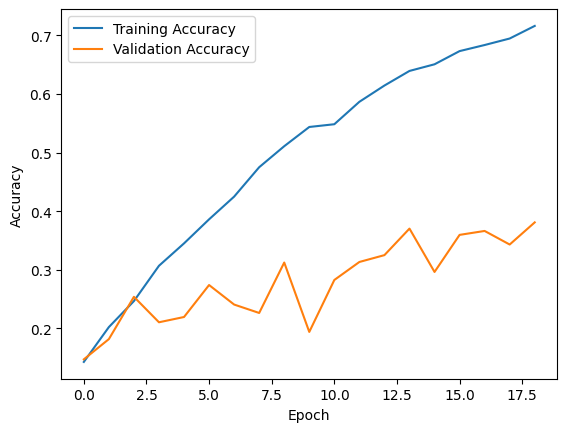

In [53]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

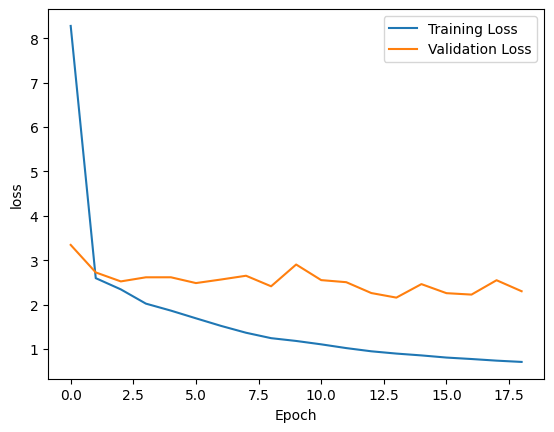

In [56]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

Look at how the accuracy for each individual genre to see if we can get any insight on what is happening, the F1 sccore gives us a general overall number on how the model is performing at identifying each genre

In [54]:
from sklearn.metrics import classification_report

# Get the predictions for the validation data
y_pred = model.predict(val_data)

# Convert the predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class for each exampley_true = []
y_true_list = []
for image, label in val_data:
    y_true_list.append(np.argmax(label.numpy(), axis=1))
y_true = np.concatenate(y_true_list)
# Compute the classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)

# Print the classification report
print(report)


164/164 [==============================] - 37s 225ms/step
{'alt': {'precision': 0.31398201144726084, 'recall': 0.2350061199510404, 'f1-score': 0.26881344067203355, 'support': 3268}, 'classical': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 22}, 'country': {'precision': 0.024390243902439025, 'recall': 0.017241379310344827, 'f1-score': 0.020202020202020204, 'support': 116}, 'edm': {'precision': 0.13674459638288486, 'recall': 0.2027468933943754, 'f1-score': 0.16332982086406742, 'support': 1529}, 'funk&soul': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 134}, 'hip hop': {'precision': 0.04721030042918455, 'recall': 0.022964509394572025, 'f1-score': 0.030898876404494385, 'support': 479}, 'jazz': {'precision': 0.013157894736842105, 'recall': 0.010526315789473684, 'f1-score': 0.011695906432748537, 'support': 95}, 'pop': {'precision': 0.18010291595197256, 'recall': 0.16535433070866143, 'f1-score': 0.1724137931034483, 'support': 1905}, 'r&b': {'precision': 0.027

In [55]:
import pandas as pd

# create dataframe from classification report
df_report = pd.DataFrame.from_dict(report).transpose()

# format float columns
df_report['precision'] = df_report['precision'].map('{:.2f}'.format)
df_report['recall'] = df_report['recall'].map('{:.2f}'.format)
df_report['f1-score'] = df_report['f1-score'].map('{:.2f}'.format)
df_report['support'] = df_report['support'].astype(int)

# print dataframe
print(df_report)

             precision recall f1-score  support
alt               0.31   0.24     0.27     3268
classical         0.00   0.00     0.00       22
country           0.02   0.02     0.02      116
edm               0.14   0.20     0.16     1529
funk&soul         0.00   0.00     0.00      134
hip hop           0.05   0.02     0.03      479
jazz              0.01   0.01     0.01       95
pop               0.18   0.17     0.17     1905
r&b               0.03   0.01     0.02      205
rock              0.26   0.33     0.29     2695
accuracy          0.22   0.22     0.22        0
macro avg         0.10   0.10     0.10    10448
weighted avg      0.22   0.22     0.22    10448


             precision recall f1-score  support
alt               0.31   0.24     0.27     3268
classical         0.00   0.00     0.00       22
country           0.02   0.02     0.02      116
edm               0.14   0.20     0.16     1529
funk&soul         0.00   0.00     0.00      134
hip hop           0.05   0.02     0.03      479
jazz              0.01   0.01     0.01       95
pop               0.18   0.17     0.17     1905
r&b               0.03   0.01     0.02      205
rock              0.26   0.33     0.29     2695
accuracy          0.22   0.22     0.22        0
macro avg         0.10   0.10     0.10    10448
weighted avg      0.22   0.22     0.22    10448